In [26]:
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import LeaveOneOut
import os

from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
from sklearn.preprocessing import label_binarize



from scipy.stats import mannwhitneyu    
from xgboost import XGBClassifier
import random
from sklearn.model_selection import KFold

# sig_data = DATA.reshape(DATA.shape[0], -1)
def train_model_using_kfold(data, label, model, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True)
    result = []

    # Loop over each train/test split
    for train_index, test_index in kf.split(data):
        # Split the data into training and testing sets
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = label[train_index], label[test_index]

        # Train the classifier
        model.fit(X_train, y_train)

        # Predict the label for the test set
        y_pred = model.predict(X_test)

        # Append the accuracy to the list
        result.append([y_pred, y_test])

    return np.array(result)


def train_model_using_loocv(data, label, model):
    loo = LeaveOneOut()
    result = []

    # Loop over each train/test split
    for train_index, test_index in loo.split(data):
        # Split the data into training and testing sets
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = label[train_index], label[test_index]

        # Train the classifier
        model.fit(X_train, y_train)

        # Predict the label for the test set
        y_pred = model.predict(X_test)

        # Append the accuracy to the list
        result.append([y_pred, y_test])

    return np.array(result), model

stats_method = 'mannwhitneyu' # 'ranksums' or 'mannwhitneyu'
def zero_diagnonal(arr):
    # Loop over the first and last dimension
    for i in range(arr.shape[0]):  # Loop over subjects
        for j in range(arr.shape[-1]):  # Loop over views
            np.fill_diagonal(arr[i, :, :, j], 0)
    return arr


def return_significant_FCvalue(adj, labels):
    adj = zero_diagnonal(adj)
    hc_adj = adj[np.where(labels==1)]
    md_adj = adj[np.where(labels==0)]
    count = 0

    num_view = adj.shape[-1]
    p_view = np.zeros((52,52,num_view))
    effect_size = np.zeros((52,52,num_view))
    stats = np.zeros((52,52,num_view))
    for view in range(num_view):
        for seed in range(52):
            for target in range(52):
                hc_val = hc_adj[:, seed, target, view]
                md_val = md_adj[:, seed, target, view]
                if stats_method == 'mannwhitneyu':
                    stat, p1 = mannwhitneyu(hc_val,md_val)

                else:
                    raise ValueError('stats_method should be mannwhitneyu or ranksums')
                p_view[seed, target, view] = p1
                stats[seed, target, view] = stat
    
    adj = adj.reshape(adj.shape[0], -1)
    p_view = p_view.reshape(-1)
    return adj[:, p_view<0.05]



# caculating_10_important_features
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from scipy.stats import skew


def get_activity_start_time(data, index_start):
    gradient = np.gradient(data)
    max_gradient = np.argmax(gradient[0:int(index_start*1.2)])  # 0:index_start*4 # current index_start = 400,
    if max_gradient <= index_start:
        max_gradient = index_start
    return max_gradient




def get_significant_feature(data, labels):
    hc_adj = data[np.where(labels==1)]
    md_adj = data[np.where(labels==0)]
    count = 0

    p_view = np.zeros((hc_adj.shape[1:]))
    for view in range(p_view.shape[-1]):
        hc_val = hc_adj[:, view]
        mdd_val = md_adj[:, view]
        _, p1 = mannwhitneyu(hc_val,mdd_val)
        p_view[view] = p1

    data = data.reshape(data.shape[0], -1)
    p_view = p_view.reshape(-1)
    data = data[:, p_view<0.05]

    return data 


def get_metrics(y_true, y_pred):
    # tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # 明确指定labels参数
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # 现在cm是一个2x2矩阵，即使数据只包含一个类别
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = f1_score(y_true, y_pred)

    return accuracy, sensitivity, specificity, f1






def print_md_table(model_name, set, metrics):
    print()
    print('| Model Name |   Set   |Accuracy | Sensitivity | Specificity | F1 Score |')
    print('|------------|----------|----------|-------------|-------------|----------|')
    print(f'| {model_name} | {set} |', end = '')
    for i in range(4):
        print(f" {metrics[i]:.4f} |", end = '')
    print()


In [6]:
def reduction_percentage(label):
    return (label[:, 1] - label[:, 0]) / label[:, 0]

In [18]:
# read data 
DATA = np.load('/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/prognosis/base_data.npy')
LABEL = np.load('/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/prognosis/base_label.npy')
LABEL = reduction_percentage(LABEL)

print(DATA.shape)

(65, 1251, 52, 2)


In [20]:
print(LABEL.shape)

(65,)


In [31]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

# Create an RVR model
rvm_model = GradientBoostingRegressor()

data = DATA[...,0].reshape(DATA.shape[0],-1)


result,model = train_model_using_loocv(data, LABEL, rvm_model)


In [27]:
from scipy.stats import pearsonr
def calculate_correlation(y_pred, y_true):
    r, p_value = pearsonr(y_true, y_pred)
    return r, p_value

(65, 2)
r -> -0.036652808298286356
p_value -> 0.7719171851636499


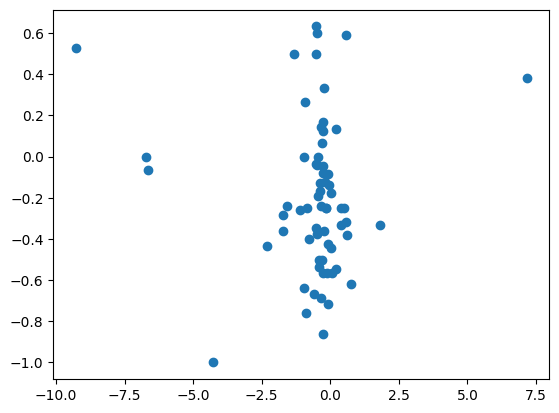

In [30]:
res = result[...,0]
print(res.shape)

plt.scatter(res[:,0], res[:,1])

r, p_value = calculate_correlation(res[:,0], res[:,1])

print('r ->', r)
print('p_value ->', p_value)

In [52]:

output_fold = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/results/ML_results'
if not os.path.exists(output_fold):
    os.makedirs(output_fold)




res = {}

# 初始化模型，同时设置随机种子
models = {
    # "Logistic Regression": LogisticRegression(max_iter=150),
    # "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    # "SVM": SVC(),
}
for name, model in models.items():
    # run multiple time, using different time stamp as random seed
    for num_time in range(1):
        print(f'current training {name}, num_time: {num_time}')

        # 使用当前时间戳作为随机种子
        current_time_seed = 1706166341

        # build model
        model.random_state = current_time_seed

        hb_result = {}
        HB_TYPE_accuraies = {}
        HB_TYPE_y_pred_and_y_test = {}
        for HB_TYPE in ['HbO', 'HbR', 'HbT']:
            HB_TYPE_accuraies[HB_TYPE] = []
            HB_TYPE_y_pred_and_y_test[HB_TYPE] = []

            # read data
            fold = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/diagnosis'

            hb = np.load(fold + '/rsfc_data.npy')
            hb = np.nan_to_num(hb)
            label = np.load(fold + '/label.npy')

            if HB_TYPE == 'HbO':
                hb = hb[..., 0]
            elif HB_TYPE == 'HbR':
                hb = hb[..., 1]
            else:
                hb = hb[..., 2]
            hb_2d = np.reshape(hb, (hb.shape[0], -1))

            # Apply LOOCV to train the model
            # Initialize LeaveOneOut
            loo = LeaveOneOut()

            # 存储每个模型的准确率
            accuracies = {}

            # Loop over each train/test split
            for train_index, test_index in loo.split(hb_2d):
                # Split the data into training and testing sets
                X_train, X_test = hb_2d[train_index], hb_2d[test_index]
                y_train, y_test = label[train_index], label[test_index]

                # Train the classifier
                model.fit(X_train, y_train)

                # Predict the label for the test set
                y_pred = model.predict(X_test)

                # Calculate the accuracy for the current fold
                accuracy = accuracy_score(y_test, y_pred)

                # Append the accuracy to the list
                HB_TYPE_accuraies[HB_TYPE].append(accuracy)

                HB_TYPE_y_pred_and_y_test[HB_TYPE].append([y_pred, y_test])
            accuracies[HB_TYPE] = 1
            accuracies[HB_TYPE] = np.mean(HB_TYPE_accuraies[HB_TYPE])

        save_result = {}
        save_result['accuracies'] = accuracies
        save_result['model_accuraies'] = HB_TYPE_accuraies
        save_result['current_time_seed'] = current_time_seed
        save_result['num_time'] = num_time
        save_result['HB_TYPE_y_pred_and_y_test'] = HB_TYPE_y_pred_and_y_test

        res[f'{num_time}'] = save_result
    # np.save(output_fold + f'/{name}_result_validate.npy', res)

current training Random Forest, num_time: 0


In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score


for hb_type in ['HbO', 'HbR', 'HbT']:
    res_true_pred = np.array(save_result['HB_TYPE_y_pred_and_y_test'][hb_type])

    y_true = res_true_pred[:, 1]
    y_pred = res_true_pred[:, 0]





    res_metrics = get_metrics(y_true, y_pred)
    print_md_table('Decision Tree', 'test' + hb_type, res_metrics)



| Model Name |   Set   |Accuracy | Sensitivity | Specificity | F1 Score |
|------------|----------|----------|-------------|-------------|----------|
| Decision Tree | testHbO | 0.6000 | 0.5286 | 0.6714 | 0.5692 |

| Model Name |   Set   |Accuracy | Sensitivity | Specificity | F1 Score |
|------------|----------|----------|-------------|-------------|----------|
| Decision Tree | testHbR | 0.4714 | 0.4571 | 0.4857 | 0.4638 |

| Model Name |   Set   |Accuracy | Sensitivity | Specificity | F1 Score |
|------------|----------|----------|-------------|-------------|----------|
| Decision Tree | testHbT | 0.4643 | 0.4571 | 0.4714 | 0.4604 |


In [90]:

while True:
    learning_rate = random.uniform(0.1, 0.6)
    model = XGBClassifier(
        learning_rate=learning_rate,
        max_depth=20,
        reg_alpha=10,
        reg_lambda=15,
        n_estimators=500
    )
# 存储每个模型的准确率
    result,model = train_model_using_loocv(RS_FC[...,-1].reshape(RS_FC.shape[0],-1), LABEL, model)
    res_metrics = get_metrics(result[:, 1], result[:, 0])
    
    # result = train_model_using_kfold(deleted_demo_data_normalized, LABEL, model)
    # res_metrics = kfold_get_metrics(result)
    print_md_table('Decision Tree', 'test', res_metrics)
    break


| Model Name |   Set   |Accuracy | Sensitivity | Specificity | F1 Score |
|------------|----------|----------|-------------|-------------|----------|
| Decision Tree | test | 0.3786 | 0.4857 | 0.2714 | 0.4387 |


In [88]:
feature_importances = model.feature_importances_
print("特征重要性：", feature_importances)

demographic_name = np.array([
    ['Age (years)', 'Sex', 'Ethnicity', 'Handedness', 'Education (years)', 
    'Current/highest education level —  Coded', 'Perceived social support', 
    'Past trauma', 'Current psychiatric comorbidities — Binary', 
    'Current psychiatric comorbidities — Coded', 'Family history of psychiatric illness']
])

for i,v in enumerate(feature_importances):
    print('Feature: %s, Score: %.5f, %0d' % (demographic_name[0][i],v,i))


特征重要性： [0.00734201 0.         0.         0.29543024 0.         0.16029395
 0.01750298 0.44857877 0.         0.07085204]
Feature: Age (years), Score: 0.00734, 0
Feature: Sex, Score: 0.00000, 1
Feature: Ethnicity, Score: 0.00000, 2
Feature: Handedness, Score: 0.29543, 3
Feature: Education (years), Score: 0.00000, 4
Feature: Current/highest education level —  Coded, Score: 0.16029, 5
Feature: Perceived social support, Score: 0.01750, 6
Feature: Past trauma, Score: 0.44858, 7
Feature: Current psychiatric comorbidities — Binary, Score: 0.00000, 8
Feature: Current psychiatric comorbidities — Coded, Score: 0.07085, 9


In [32]:
def kfold_get_metrics(result):
    folds_result = []
    for i in range(len(result)):
        x = get_metrics(result[i,1], result[i,0])
        folds_result.append(x)

    folds_result = np.array(folds_result)
    folds_result = np.mean(folds_result, axis=0)
    return folds_result